# Notebook III: Generative Evaluation of Audio Representations

## Motivation
-------------

Within the domain of machine listening, frameworks like the "Holistic Evaluation of Audio Representations" (HEAR) provide comprehensive methodologies for assessing statistical models across multiple machine listening tasks. While HEAR provides a uniform basis for comparison across deep learning models and datasets, direct interpretation in terms of audio signal processing remains elusive.

In this tutorial, we explore an evaluation approach within the Generative Evaluation of Audio Representations (GEAR) framework [2]. Here, the emphasis is on the generation of datasets comprising sounds characterized by a select number of independent factors of acoustic variability. 

Using the Kymatio package, we explore the acoustic representation of amplitude and frequency modulated audio signals, with the motivation to understand and visualize the signal characteristics represented by scattering and time-frequency scattering transforms (as in [1]). We use this framework as a basis for comparing scattering transforms to other time-frequency and deep feature acoustic representations that are commonly used to evaluate audio generation systems and sound similarity.

## Task 
-------
We will construct and embed a dataset of signals with the Isomap manifold embedding algorithm which, when effectively represented, should materialize as a mesh-like manifold, that suggests a linear correlation of its principal components with the parameters of the given sound synthesizer, hence exhibiting disentanglement of these acoustic properties.

We will implement two parametric synthesizers that produce complex tones: 

1. an additive Fourier synthesizer, characterized by 3 parameters: fundamental frequency, Fourier decay (brightness) and odd-even harmonic ratio
2. a chirplet arpeggiator, described by 3 parameters: centre frequency, amplitude modulator rate, and exponential chirp rate

The first synthesizer has sustained pitch, with varying spectral shape that can simulate the tone of instruments such as flute or clarinet. The second synthesizer's frequency is non-stationary and contains amplitude modulations of varying rate. In both cases, it's trivial for the human auditory system to independently hear the similarities and differences between sounds varying in these 3 parameters.

Both synthesizers are implemented such that they have exactly 3 degrees of freedom and independent acoustic factors of variability. This make it possible to visualize the disentanglement of said parameters. We generate a dataset of signals for each synthesizer, spanning a 3D parameter grid. Then, we compute the manifold embedding of the nearest neighbor graph using the Isomap algorithm for a number of acoustic representations of the dataset:

1. Mel-frequency Cepstral Coefficients
2. Time Scattering
3. Time-Frequency Scattering
4. Open-L3 deep feature embeddings (music encoder)
5. CREPE
6. wav2vec2

By situating a paradigm akin to GEAR, we aim to highlight the distinctions and intricacies of various audio embeddings, deepening the understanding and capability to evaluate audio representations in the field of machine listening research.

## References
----------
1. ["Differentiable Time-Frequency Scattering on GPU" by John Muradeli, Cyrus Vahidi, Changhong Wang, Han Han, Vincent Lostanlen, Mathieu Lagrange, George Fazekas](https://arxiv.org/abs/2204.08269)

2. ["From HEAR to GEAR: Generative Evaluation of Audio Representations" by Vincent Lostanlen, Lingyao Yan, Xianyi Yang](https://hal.science/hal-03979667/)

In [7]:
import warnings

import librosa
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy
from IPython.display import Audio
from sklearn.manifold import Isomap

from kymatio.torch import Scattering1D, TimeFrequencyScattering

warnings.filterwarnings("ignore")

%matplotlib inline

## Chirplet Arpeggiator Generation
----------------------------------

In [8]:
def gauss_window(M: float, std: torch.FloatTensor, sym: bool = True):
    """
    Returns a Gaussian window tensor.

    This function generates a Gaussian window, given the window length and standard deviation.
    It's an adapted version from scipy.signal.gaussian.

    Args:
        M (float): The number of points in the output window.
        std (torch.FloatTensor): Standard deviation of the Gaussian window.
        sym (bool, optional): When True (default), generates a symmetric window for filter design.
            If False, the window is not symmetric.

    Returns:
        torch.Tensor: The generated Gaussian window tensor of shape (M,).

    Notes:
        If M < 1, an empty tensor is returned.
        If M == 1, a tensor with a single value of 1 is returned.
    """
    if M < 1:
        return torch.array([])
    if M == 1:
        return torch.ones(1, "d").type_as(std)
    odd = M % 2
    if not sym and not odd:
        M = M + 1
    n = torch.arange(0, M) - (M - 1.0) / 2.0
    n = n.type_as(std)

    sig2 = 2 * std * std
    w = torch.exp(-(n**2) / sig2)
    if not sym and not odd:
        w = w[:-1]
    return w


def generate_am_chirp(
    theta: torch.FloatTensor,
    bw: float = 2,
    duration: float = 4,
    sr: float = 2**13,
    delta: int = 0,
):
    """
    Generate an amplitude-modulated (AM) chirp signal.

    The function generates an AM chirp signal windowed in the time domain by a Gaussian function.

    Args:
        theta (torch.FloatTensor): A tensor containing:
            - The carrier frequency (f_c) in Hz.
            - The modulator frequency (f_m) in Hz.
            - The chirp rate (gamma) in octaves/second.
        bw (float, optional): The bandwidth of the chirp signal in octaves. Defaults to 2.
        duration (float, optional): The duration of the chirp signal in seconds. Defaults to 4.
        sr (float, optional): The sample rate of the chirp signal in samples per second. Defaults to 2**13.
        delta (int, optional): Applies a time shift in samples. (Currently unused in the function.)

    Returns:
        torch.Tensor: The generated amplitude-modulated chirp signal.

    Example:
        >>> theta = [torch.tensor(512.0), torch.tensor(8.0), torch.tensor(1.8)]
        >>> signal = generate_am_chirp(theta, bw=5, duration=2, sr=44100, delta=100)
        >>> signal.shape
    """
    f_c, f_m, gamma = theta[0], theta[1], theta[2]
    t = torch.arange(-duration / 2, duration / 2, 1 / sr).type_as(f_m)
    carrier = sine(f_c / (gamma * np.log(2)) * (2 ** (gamma * t) - 1))
    modulator = sine(t * f_m)
    sigma0 = 0.1
    window_std = (torch.tensor(sigma0 * bw).type_as(gamma)) / gamma
    window = gauss_window(duration * sr, std=window_std * sr)
    x = carrier * (modulator if f_m != 0 else 1.0) * window * float(gamma)
    # if delta:
    #     x = time_shift(x, delta)
    return x


def sine(f):
    """
    Compute the sine of a given instantaneous frequency.

    Args:
        f (torch.Tensor): The instantaneous frequencies.

    Returns:
        torch.Tensor: sine signal.
    """
    return torch.sin(2 * torch.pi * f)


def plot_cqt(y, hop_length=32, bins_per_octave=24, sr=2**13, ax=None):
    """
    Plot the Constant-Q Transform (CQT) of a given signal.

    This function uses the librosa library to compute and display the CQT of the input signal `y`.

    Args:
        y (np.ndarray): The input signal for which the CQT will be computed.
        hop_length (int, optional): The number of samples between successive CQT columns. Defaults to 32.
        bins_per_octave (int, optional): Number of bins per octave. Determines the resolution of the CQT. Defaults to 24.
        sr (int, optional): The sampling rate of the input signal in Hz. Defaults to 2**13.
        ax (matplotlib.axes.Axes, optional): The axes on which to display the CQT. If None (default), the current active axis will be used.

    Notes:
        The function uses a fixed fmin (minimum frequency) of 2**6 Hz.
        The `n_bins` parameter for the CQT computation is fixed at 120.
        The displayed CQT magnitude is scaled by raising to the power of 0.33 to improve visibility.
        The y-axis limit of the plot is commented out, but can be adjusted by uncommenting and modifying the `plt.ylim` line.
    """
    cqt_kwargs = {
        "sr": sr,
        "fmin": 2**6,
        "bins_per_octave": bins_per_octave,
        "hop_length": hop_length,
    }
    CQT = librosa.cqt(y, n_bins=120, **cqt_kwargs)
    librosa.display.specshow((np.abs(CQT) ** 0.33), **cqt_kwargs, ax=ax)


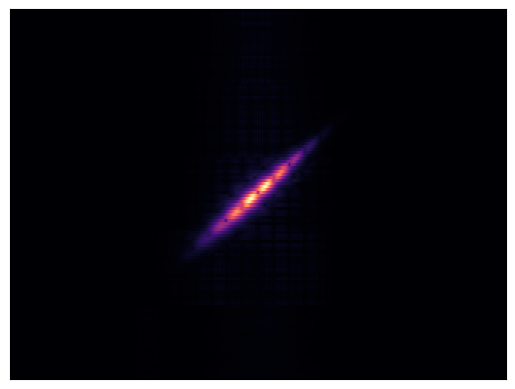

In [9]:
SR = 2**13

fc = 362 #@param {type:"slider", min:128.0, max:1024.0, step:1.0}
am = 4 #@param {type:"slider", min:4.0, max:16.0, step:1.0}
fm = 1.5 #@param {type:"slider", min:0.5, max:4.0, step:0.5}

fc = torch.tensor([fc], dtype=torch.float32)
am = torch.tensor([am], dtype=torch.float32)
fm = torch.tensor([fm], dtype=torch.float32)
x = generate_am_chirp([fc, am, fm], bw=2, duration=4)


plot_cqt(x.numpy(), sr=SR)
Audio(x, rate=SR)

## Isomap: Manifold Embedding of the Nearest Neighbor Graph
-----------------------------------------------------------

In [10]:
def fit_isomap(X, n_neighbors=40):
    """
    Apply the Isomap algorithm on a given dataset and visualize the results.
    
    Parameters:
    -----------
    X : numpy.array
        The high-dimensional data that the Isomap algorithm will be applied on.
        Shape: (n_samples, n_features)
        
    params : list of numpy.array
        A list containing 3 arrays which represent the parameters to be used 
        for color-coding in the 3D plots. Each array should match the number of 
        data points in `X`.
        
    n_neighbors : int, optional (default: 40)
        The number of neighbors to consider for each data point when constructing
        the Isomap embedding.
        
    Returns:
    --------
        model  :
        Y : 
        axs  :
        The function visualizes the Isomap embedding using the `plot_isomap` function.
    """
    model = Isomap(n_components=3, n_neighbors=n_neighbors)
    Z = model.fit_transform(X)

    return Z, model


def plot_isomap(Z, params, labels=[]):
    """
    Visualize the Isomap embedding in a 3D plot with parameters for color-coding.
    
    Parameters:
    -----------
    Z : numpy.array
        The reduced data after Isomap embedding. 
        Shape: (n_samples, 3)
        
    params : list of numpy.array
        A list containing 3 arrays which represent the parameters to be used 
        for color-coding in the 3D plots. Each array should match the number of 
        data points in `Z`.
    
    labels : list of str
        A list containing 3 labels, one for each of the plots to indicate the parameter 
        that has been used for color-coding
        
    Returns:
    --------
    ax
        The function visualizes the 3D plots for the Isomap embedding with 
        different color codings based on `params`.
    """
    fig = plt.figure(figsize=plt.figaspect(0.5))
    axs = []

    for i in range(3):
        ax = fig.add_subplot(1, 3, i + 1, projection='3d')
        ax.scatter3D(Z[:, 0], Z[:, 1], Z[:, 2], c=params[i], cmap='bwr');

        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        axs.append(ax)

    plt.subplots_adjust(wspace=0, hspace=0)

    # rotate the axes and update
    for angle in range(60, 360, 60):
        for ax in axs:
            ax.view_init(30, angle)
            plt.draw()

## Generating the parametric synth dataset
------------------------------------------

In [11]:
#@title Synthetic AM chirp dataset generation
#@markdown We generate 4096 signals lying on a 3D manifold in ($f_c$, $f_m$, $\gamma$)

#@markdown $f_c \in [512, 1024]$

#@markdown $f_m \in [4, 16]$

#@markdown $\gamma \in [0.5, 4]$

# Defining the number of steps for parameter values and the range for each parameter
n_steps = 16
f0_min, f0_max = 512, 1024
am_min, am_max = 4, 16
fm_min, fm_max = 0.5, 4
bw = 2
duration = 4
sr = 2**13

# Generating logarithmically spaced values for each parameter across the specified range
f0s = np.logspace(np.log10(f0_min), np.log10(f0_max), n_steps)
AM = np.logspace(np.log10(am_min), np.log10(am_max), n_steps)
FM = np.logspace(np.log10(fm_min), np.log10(fm_max), n_steps)

# Initializing audio array to store synthesized signals and params array for parameters
audio = np.zeros((len(f0s), len(AM), len(FM), duration * sr))
params = np.zeros((3, len(f0s) * len(AM) * len(FM)))
c = 0

# Nested loops to generate audio for each combination of parameter values
for i, f0 in enumerate(f0s):
    for j, am in enumerate(AM):
        for k, fm in enumerate(FM):
            # Create the parameter tensor for AM chirp generation
            theta = torch.tensor([f0, am, fm])
            # Generate the AM chirp signal for given parameters and normalize it
            x = generate_am_chirp(theta, sr=sr, duration=duration).numpy()
            audio[i, j, k, :] = x / np.linalg.norm(x)
            # Storing the parameter values in the params array
            params[0, c], params[1, c], params[2, c] = f0, am, fm
            c += 1 # Incrementing the counter for the next parameter combination

## Isomap of MFCCs
------------------

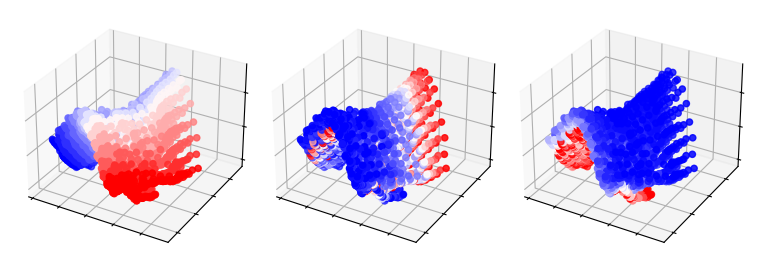

In [12]:
#@title Similarity Retrieval - `MFCC`

# Set the number of MFCC coefficients to extract
n_mfcc = 40

# Initialize an array to store the MFCC coefficients for each audio signal in the dataset
Sx = np.zeros((len(f0s), len(AM), len(FM), n_mfcc))

# Nested loops to compute MFCCs for each audio signal in the dataset
for i, f0 in enumerate(f0s):             # Iterate over all values of f0
    for j, fm in enumerate(AM):                     # Iterate over all values of AM
        for k, gamma in enumerate(FM):              # Iterate over all values of FM
            # Compute the MFCCs for the specific audio signal and average them across time (axis=-1)
            Sx[i, j, k, :] = np.mean(librosa.feature.mfcc(y=audio[i, j, k], sr=sr, n_mfcc=n_mfcc), axis=-1)

# Reshape the 4D MFCCs array into a 2D array where each row is the MFCC vector for a specific audio signal
mfccs = Sx.reshape(-1, Sx.shape[-1])

Z, _ = fit_isomap(X=mfccs)
plot_isomap(Z, params)
plt.show()

## Isomap of Scattering1D
-------------------------

## Isomap of TimeFrequencyScattering
------------------------------------

## Isomap of OpenL3
-------------------